---

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import lime
import lime.lime_tabular



import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)




In [48]:

# Load your data
data_2021 = pd.read_csv("https://raw.githubusercontent.com/Keltings/Data/refs/heads/main/selected_2021_data.csv")
data_2016 = pd.read_csv("https://raw.githubusercontent.com/Keltings/Data/refs/heads/main/selected_2016_data.csv")

# Drop ID
data_2021.drop(columns=["respondent_id"], inplace=True)
data_2016.drop(columns=["respondent_id"], inplace=True)

# Target
target_col = "financially_excluded"
data_2021[target_col] = data_2021[target_col].map({"yes": 1, "no": 0})
data_2016[target_col] = data_2016[target_col].map({"yes": 1, "no": 0})

# Binary Mapping for behavioral features
behavior_cols = [col for col in data_2021.columns if col not in ["age", "gender", "education_level", "residence_type", 
                                                                 "marital_status", "relationship_to_hh", "region", 
                                                                 "population_weight", "financially_excluded"]]

for col in behavior_cols:
    data_2021[col] = data_2021[col].map({"yes": 1, "no": 0})
    data_2016[col] = data_2016[col].map({"yes": 1, "no": 0})

# 🔧 Feature Engineering - Reduce Inputs

def simplify_features(df):
    engineered = pd.DataFrame()

    # Keep demographic fields
    engineered["age"] = df["age"]
    engineered["gender"] = df["gender"]
    engineered["education_level"] = df["education_level"]
    engineered["residence_type"] = df["residence_type"]
    engineered["marital_status"] = df["marital_status"]
    engineered["relationship_to_hh"] = df["relationship_to_hh"]
    engineered["region"] = df["region"]
    engineered["population_weight"] = df["population_weight"]

    # ✅ Mobile money access
    engineered["mobile_money_access"] = df["mobile_money_registered"]

    # ✅ Banking behavior (any formal bank engagement)
    bank_features = ["bank_account_current", "bank_account_savings", "bank_account_everyday",
                     "postbank_account", "bank_overdraft", "debit_card", "credit_card"]
    engineered["formal_bank_user"] = df[bank_features].max(axis=1)

    # ✅ Savings behavior
    savings_features = ["savings_mobile_banking", "savings_microfinance", "savings_sacco",
                        "savings_group_friends", "savings_family_friend", "savings_secret_place"]
    engineered["saves_money"] = df[savings_features].max(axis=1)

    # ✅ Loan access behavior
    loan_features = ["loan_bank", "loan_mobile_banking", "loan_sacco", "loan_microfinance",
                     "loan_shylock", "loan_group_chama", "loan_govt", "loan_employer", 
                     "loan_family_friend", "loan_shopkeeper_cash", "loan_goods_credit",
                     "loan_digital_app", "loan_agri_buyer_supplier", "loan_hire_purchase", "loan_mortgage"]
    engineered["has_taken_loan"] = df[loan_features].max(axis=1)

    # ✅ Insurance Access
    insurance_cols = ["insurance_motor", "insurance_home", "insurance_crop", "insurance_livestock",
                      "insurance_nhif", "insurance_health_other", "insurance_life", "insurance_education",
                      "insurance_other"]
    engineered["has_insurance"] = df[insurance_cols].max(axis=1)

    # ✅ Pension Access
    pension_cols = ["pension_nssf", "pension_mbao", "pension_other"]
    engineered["has_pension"] = df[pension_cols].max(axis=1)

    return engineered

# Apply it to both datasets
X_train_engineered = simplify_features(data_2021)
X_test_engineered = simplify_features(data_2016)

# Extract target
y_train = data_2021["financially_excluded"]
y_test = data_2016["financially_excluded"]


In [68]:
print("Features used during training:")
print(X_train_full_smote.columns.tolist())


Features used during training:
['age', 'gender_female', 'gender_male', 'education_level_primary', 'education_level_secondary', 'education_level_tertiary', 'education_level_unknown', 'residence_type_rural', 'residence_type_urban', 'marital_status_divorced/separated', 'marital_status_married/living with partner', 'marital_status_single', 'marital_status_unknown', 'marital_status_widowed', 'region_central', 'region_central rift', 'region_coast', 'region_lower eastern', 'region_mid eastern', 'region_nairobi', 'region_north eastern', 'region_north rift', 'region_nyanza', 'region_south rift', 'region_upper eastern', 'region_western', 'mobile_money_access', 'formal_bank_user', 'saves_money', 'has_taken_loan', 'has_insurance', 'has_pension']


In [65]:
X_train_full

,age,population_weight,gender_female,gender_male,education_level_primary,education_level_secondary,education_level_tertiary,education_level_unknown,residence_type_rural,residence_type_urban,marital_status_divorced/separated,marital_status_married/living with partner,marital_status_single,marital_status_unknown,marital_status_widowed,region_central,region_central rift,region_coast,region_lower eastern,region_mid eastern,region_nairobi,region_north eastern,region_north rift,region_nyanza,region_south rift,region_upper eastern,region_western,mobile_money_access,formal_bank_user,saves_money,has_taken_loan,has_insurance,has_pension
0,50,1836,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,1,1
1,59,1506,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,1
2,52,1336,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,1,0
3,75,2493,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0
4,24,1980,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20904,31,4313,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0
20905,62,3546,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
20906,28,2747,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0
20907,30,3152,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [49]:

# Columns to one-hot encode
categorical_demo = ["gender", "education_level", "residence_type", "marital_status", "region"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Separate numerical demo columns
numerical_demo = ["age", "population_weight"]

# 👉 Prepare Demographics Only Dataset
X_train_demo_raw = X_train_engineered[categorical_demo + numerical_demo]
X_test_demo_raw = X_test_engineered[categorical_demo + numerical_demo]

# 👉 Fit and Transform encoder
X_train_demo_encoded = encoder.fit_transform(X_train_demo_raw[categorical_demo])
X_test_demo_encoded = encoder.transform(X_test_demo_raw[categorical_demo])
encoded_names = encoder.get_feature_names_out(categorical_demo)

# 👉 Rebuild full encoded demo set
X_train_demo = pd.concat([
    X_train_demo_raw[numerical_demo].reset_index(drop=True),
    pd.DataFrame(X_train_demo_encoded, columns=encoded_names)
], axis=1)

X_test_demo = pd.concat([
    X_test_demo_raw[numerical_demo].reset_index(drop=True),
    pd.DataFrame(X_test_demo_encoded, columns=encoded_names)
], axis=1)

# Drop population_weight before SMOTE
X_train_demo_for_smote = X_train_demo.drop(columns=["population_weight"])

# 🔁 Apply SMOTE to Demographics Only
smote = SMOTE(random_state=42)
X_train_demo_smote, y_train_demo_smote = smote.fit_resample(X_train_demo_for_smote, y_train)

# Add population_weight back (optional if used downstream)
X_train_demo_smote["population_weight"] = 1

# --- ✅ DEMO + BEHAVIOR ---
# Append engineered behavior columns
behavior_cols = ["mobile_money_access", "formal_bank_user", "saves_money", "has_taken_loan", "has_insurance", "has_pension"]
X_train_full = pd.concat([X_train_demo, X_train_engineered[behavior_cols].reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test_demo, X_test_engineered[behavior_cols].reset_index(drop=True)], axis=1)

# Drop population weight before SMOTE
X_train_full_for_smote = X_train_full.drop(columns=["population_weight"])

# 🔁 Apply SMOTE to Full Dataset
X_train_full_smote, y_train_full_smote = smote.fit_resample(X_train_full_for_smote, y_train)
# X_train_full_smote["population_weight"] = 1


In [70]:
X_train_full_smote

,age,gender_female,gender_male,education_level_primary,education_level_secondary,education_level_tertiary,education_level_unknown,residence_type_rural,residence_type_urban,marital_status_divorced/separated,marital_status_married/living with partner,marital_status_single,marital_status_unknown,marital_status_widowed,region_central,region_central rift,region_coast,region_lower eastern,region_mid eastern,region_nairobi,region_north eastern,region_north rift,region_nyanza,region_south rift,region_upper eastern,region_western,mobile_money_access,formal_bank_user,saves_money,has_taken_loan,has_insurance,has_pension
0,50,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,1,1,0,1,1
1,59,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,0,0,0,1,1
2,52,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,1,0,0,1,0
3,75,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,0,1,0,0,0
4,24,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37887,25,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.635151,0.000000,0.0,0.000000,0.0,0.364849,0.000000,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0
37888,42,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.745915,0.254085,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.745915,0.0,0.000000,0.254085,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0
37889,85,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,0.229164,0.0,0.770836,0.000000,0.000000,0.770836,0.0,0.000000,0.0,0.000000,0.229164,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0
37890,40,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.770622,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.229378,0,0,0,0,0,0


In [50]:

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=6),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
}

# Evaluate models with a utility function
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    print(f"\n📌 Classification Report ({name}):")
    print(classification_report(y_test, y_pred, target_names=["Included", "Excluded"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=["Included", "Excluded"],
                yticklabels=["Included", "Excluded"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    return {
        "Accuracy": model.score(X_test, y_test),
        "Precision": classification_report(y_test, y_pred, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, y_pred, output_dict=True)["1"]["recall"],
        "F1": classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
        "ROC AUC": roc_auc
    }

# Fixing column mismatch before training/evaluation
X_test_demo = X_test_demo.reindex(columns=X_train_demo_smote.columns, fill_value=0)
X_test_full = X_test_full.reindex(columns=X_train_full_smote.columns, fill_value=0)



📌 Demographics Only (SMOTE)

📌 Classification Report (Logistic Regression - Demographics Only (SMOTE)):
              precision    recall  f1-score   support

    Included       0.91      1.00      0.96      7507
    Excluded       0.00      0.00      0.00       701

    accuracy                           0.91      8208
   macro avg       0.46      0.50      0.48      8208
weighted avg       0.84      0.91      0.87      8208



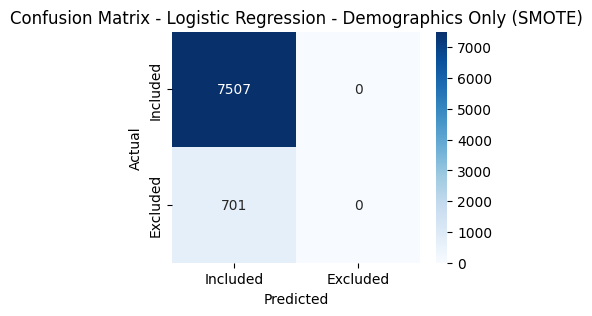

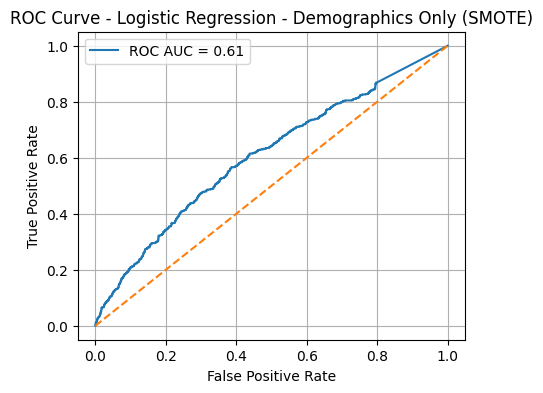


📌 Classification Report (Decision Tree - Demographics Only (SMOTE)):
              precision    recall  f1-score   support

    Included       0.98      0.76      0.86      7507
    Excluded       0.26      0.87      0.40       701

    accuracy                           0.77      8208
   macro avg       0.62      0.82      0.63      8208
weighted avg       0.92      0.77      0.82      8208



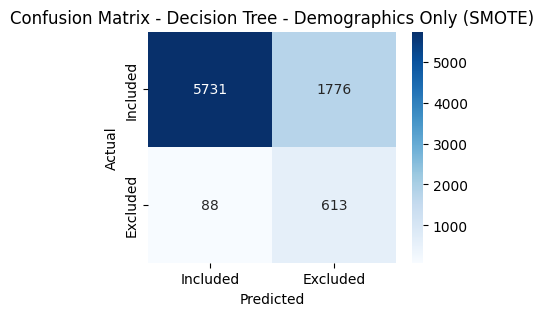

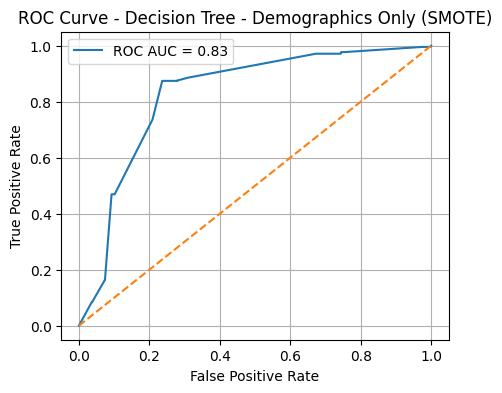


📌 Classification Report (Random Forest - Demographics Only (SMOTE)):
              precision    recall  f1-score   support

    Included       0.97      0.85      0.91      7507
    Excluded       0.31      0.71      0.43       701

    accuracy                           0.84      8208
   macro avg       0.64      0.78      0.67      8208
weighted avg       0.91      0.84      0.87      8208



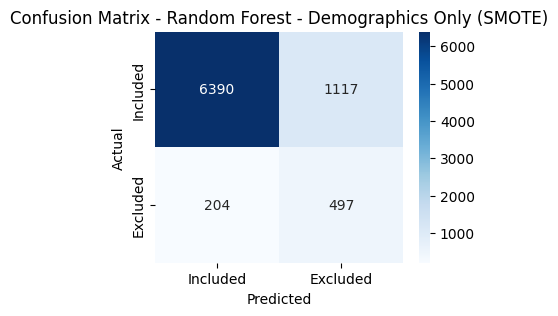

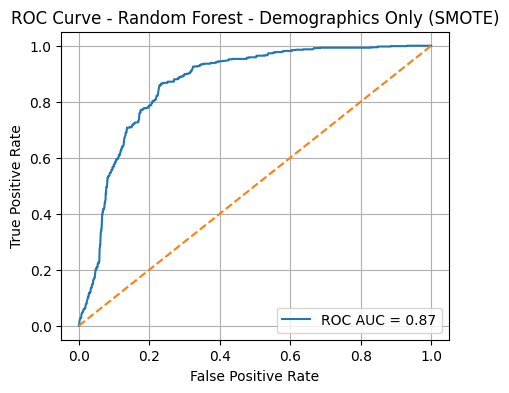


📌 Classification Report (Gradient Boosting - Demographics Only (SMOTE)):
              precision    recall  f1-score   support

    Included       0.96      0.89      0.93      7507
    Excluded       0.34      0.57      0.43       701

    accuracy                           0.87      8208
   macro avg       0.65      0.73      0.68      8208
weighted avg       0.90      0.87      0.88      8208



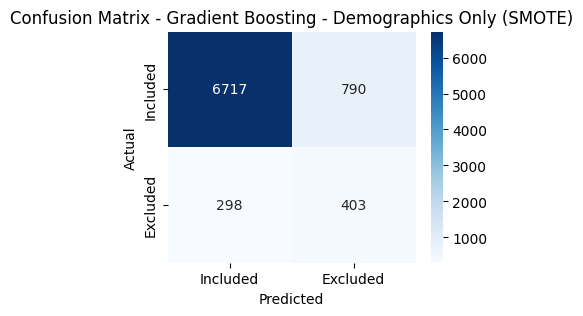

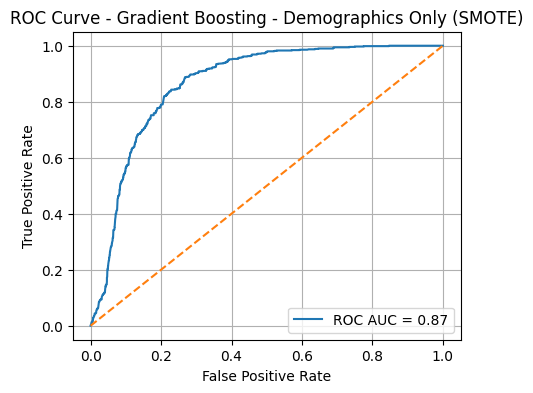


📌 Demographics + Behavior (SMOTE)

📌 Classification Report (Logistic Regression - Demographics + Behavior (SMOTE)):
              precision    recall  f1-score   support

    Included       1.00      0.93      0.96      7507
    Excluded       0.56      1.00      0.72       701

    accuracy                           0.93      8208
   macro avg       0.78      0.96      0.84      8208
weighted avg       0.96      0.93      0.94      8208



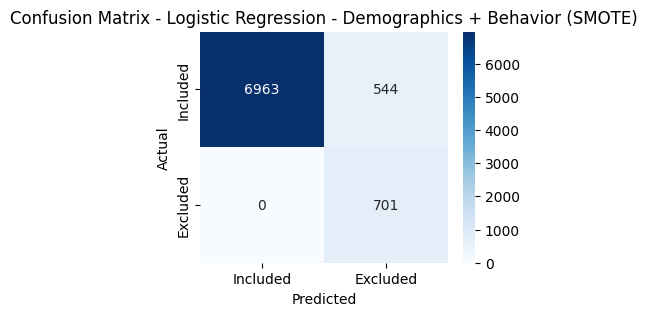

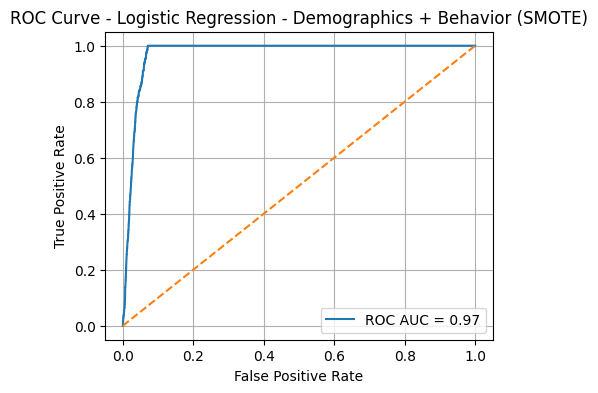


📌 Classification Report (Decision Tree - Demographics + Behavior (SMOTE)):
              precision    recall  f1-score   support

    Included       1.00      0.93      0.96      7507
    Excluded       0.56      1.00      0.72       701

    accuracy                           0.93      8208
   macro avg       0.78      0.96      0.84      8208
weighted avg       0.96      0.93      0.94      8208



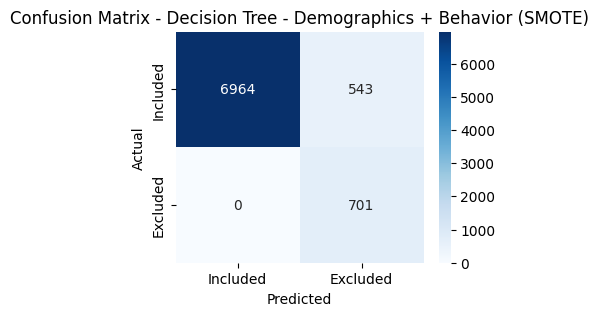

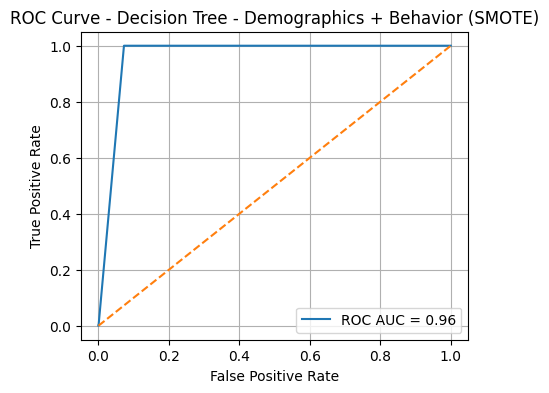


📌 Classification Report (Random Forest - Demographics + Behavior (SMOTE)):
              precision    recall  f1-score   support

    Included       1.00      0.93      0.96      7507
    Excluded       0.56      1.00      0.72       701

    accuracy                           0.93      8208
   macro avg       0.78      0.96      0.84      8208
weighted avg       0.96      0.93      0.94      8208



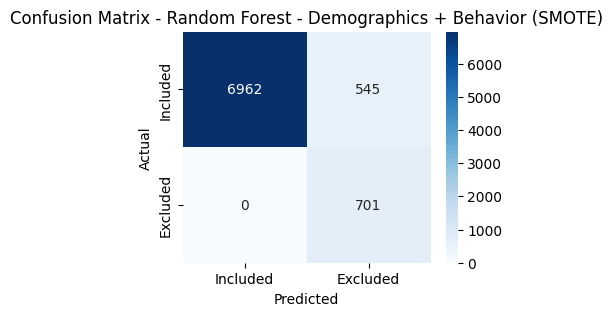

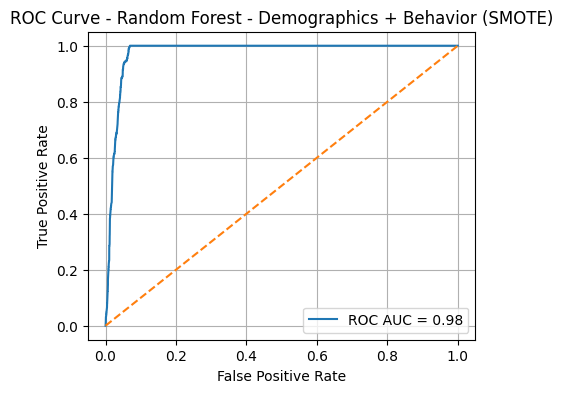


📌 Classification Report (Gradient Boosting - Demographics + Behavior (SMOTE)):
              precision    recall  f1-score   support

    Included       1.00      0.93      0.96      7507
    Excluded       0.56      1.00      0.72       701

    accuracy                           0.93      8208
   macro avg       0.78      0.96      0.84      8208
weighted avg       0.96      0.93      0.94      8208



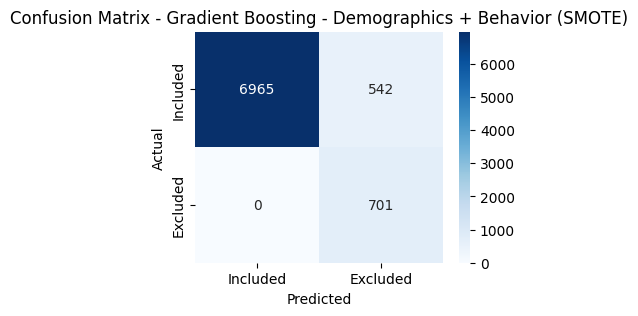

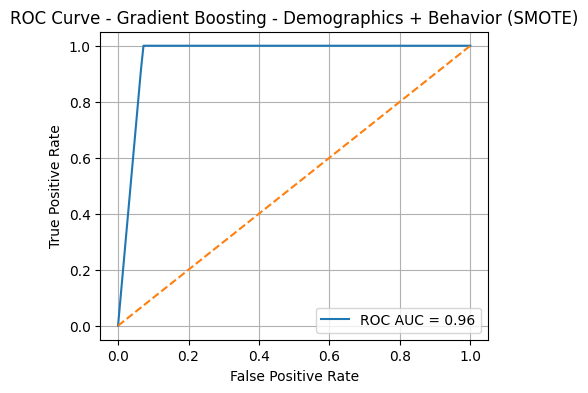

In [51]:
# Example usage (make sure you've defined classifiers properly above)
results_demo_smote = {}
results_full_smote = {}

print("📌 Demographics Only (SMOTE)")
for name, model in classifiers.items():
    results_demo_smote[name] = evaluate_model(
        f"{name} - Demographics Only (SMOTE)",
        model, X_train_demo_smote, X_test_demo,
        y_train_demo_smote, y_test
    )

print("\n📌 Demographics + Behavior (SMOTE)")
for name, model in classifiers.items():
    results_full_smote[name] = evaluate_model(
        f"{name} - Demographics + Behavior (SMOTE)",
        model, X_train_full_smote, X_test_full,
        y_train_full_smote, y_test
    )


In [52]:

# Convert results to DataFrame
df_demo_smote = pd.DataFrame(results_demo_smote).T.round(4)
df_full_smote = pd.DataFrame(results_full_smote).T.round(4)

# Display
print("📌 Performance (SMOTE) — Demographics Only")
display(df_demo_smote)

print("📌 Performance (SMOTE) — Demographics + Behavior")
display(df_full_smote)


📌 Performance (SMOTE) — Demographics Only


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.9146,0.0000,0.0000,0.0000,0.6067
Decision Tree,0.7729,0.2566,0.8745,0.3968,0.8264
Random Forest,0.8391,0.3079,0.7090,0.4294,0.8650
Gradient Boosting,0.8674,0.3378,0.5749,0.4256,0.8658


📌 Performance (SMOTE) — Demographics + Behavior


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.9337,0.5631,1.0,0.7205,0.9736
Decision Tree,0.9338,0.5635,1.0,0.7208,0.9638
Random Forest,0.9336,0.5626,1.0,0.7201,0.9767
Gradient Boosting,0.9340,0.5640,1.0,0.7212,0.9644


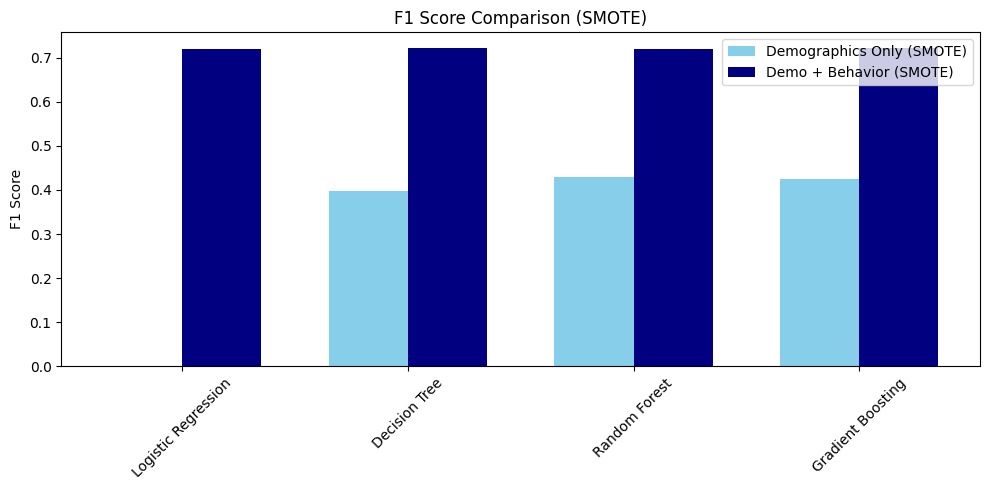

In [53]:
models = df_demo_smote.index.tolist()
f1_demo = df_demo_smote["F1"].tolist()
f1_full = df_full_smote["F1"].tolist()

x = np.arange(len(models))
width = 0.35

# F1 Score Comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, f1_demo, width, label='Demographics Only (SMOTE)', color='skyblue')
ax.bar(x + width/2, f1_full, width, label='Demo + Behavior (SMOTE)', color='navy')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison (SMOTE)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


In [54]:
best_model_name = df_full_smote["F1"].idxmax()
print(f"🏆 Best model is: {best_model_name}")


🏆 Best model is: Gradient Boosting


In [78]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10]
}

best_model = classifiers[best_model_name.split(" - ")[0]]

random_search = RandomizedSearchCV(best_model, param_grid, scoring="f1", cv=5)
random_search.fit(X_train_full_smote, y_train_full_smote)



KeyboardInterrupt: 

In [56]:
print("🌟 Best parameters:", random_search.best_params_)
optimized_model = random_search.best_estimator_


🌟 Best parameters: {'min_samples_split': 2, 'max_depth': 3}


LIME explanation saved as 'lime_explanation.html'. Open it in your browser.


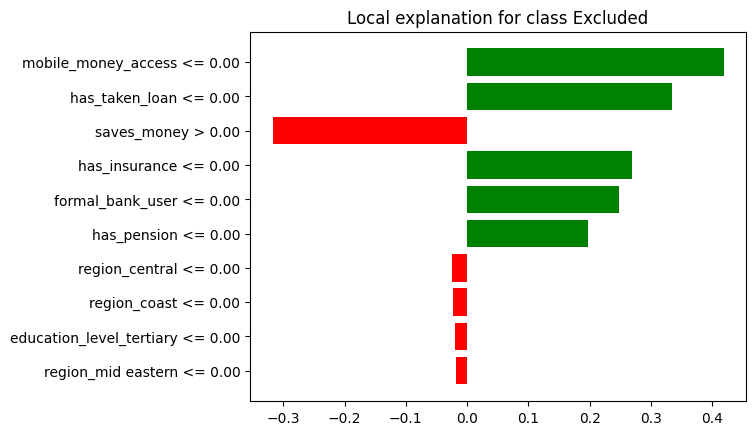

In [87]:
import lime
import lime.lime_tabular
from IPython.display import display

# Initialize LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_full_smote.values,
    feature_names=X_train_full_smote.columns,
    class_names=["Included", "Excluded"],
    mode="classification"
)

# Select an instance for explanation
index = 1000  # Change this index to any row in X_test_full

# Generate LIME explanation
exp = lime_explainer.explain_instance(
    X_test_full.iloc[index].values, 
    optimized_model.predict_proba
)

# Display LIME explanation in Jupyter Notebook
# Save visualization
exp.save_to_file("lime_explanation.html")
print("LIME explanation saved as 'lime_explanation.html'. Open it in your browser.")

# Optional: Show explanation in a Matplotlib plot
fig = exp.as_pyplot_figure()
plt.show()



In [59]:
import joblib

joblib.dump(optimized_model, "best_financial_exclusion_model.pkl")
print("🚀 Model saved for deployment.")


🚀 Model saved for deployment.


In [60]:
import joblib

# Save your fitted encoder
joblib.dump(encoder, "onehot_encoder.pkl")
print("✅ OneHotEncoder saved as onehot_encoder.pkl")


✅ OneHotEncoder saved as onehot_encoder.pkl


In [73]:
import joblib

# columns_full_features was defined after preprocessing your data:
columns_full_features = X_test_full.columns.tolist()

# Save columns for future use
joblib.dump(columns_full_features, "columns_full_features.pkl")
print("✅ Feature columns saved as columns_full_features.pkl")


✅ Feature columns saved as columns_full_features.pkl


In [75]:
X_train_full

,age,population_weight,gender_female,gender_male,education_level_primary,education_level_secondary,education_level_tertiary,education_level_unknown,residence_type_rural,residence_type_urban,marital_status_divorced/separated,marital_status_married/living with partner,marital_status_single,marital_status_unknown,marital_status_widowed,region_central,region_central rift,region_coast,region_lower eastern,region_mid eastern,region_nairobi,region_north eastern,region_north rift,region_nyanza,region_south rift,region_upper eastern,region_western,mobile_money_access,formal_bank_user,saves_money,has_taken_loan,has_insurance,has_pension
0,50,1836,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,1,1
1,59,1506,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,1
2,52,1336,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,1,0
3,75,2493,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0
4,24,1980,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20904,31,4313,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0
20905,62,3546,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
20906,28,2747,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0
20907,30,3152,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [62]:
print("Columns loaded from columns_full_features.pkl:", columns_full_features)

Columns loaded from columns_full_features.pkl: ['age', 'population_weight', 'gender_female', 'gender_male', 'education_level_primary', 'education_level_secondary', 'education_level_tertiary', 'education_level_unknown', 'residence_type_rural', 'residence_type_urban', 'marital_status_divorced/separated', 'marital_status_married/living with partner', 'marital_status_single', 'marital_status_unknown', 'marital_status_widowed', 'region_central', 'region_central rift', 'region_coast', 'region_lower eastern', 'region_mid eastern', 'region_nairobi', 'region_north eastern', 'region_north rift', 'region_nyanza', 'region_south rift', 'region_upper eastern', 'region_western', 'mobile_money_access', 'formal_bank_user', 'saves_money', 'has_taken_loan', 'has_insurance', 'has_pension']
